## Figure 4: Fitting a GLM to Real Data

This notebook recreates the figure panels included in Figure 4 of [Bolkan, Stone et al 2021](https://www.biorxiv.org/content/10.1101/2021.07.23.453573v1). It also serves as a useful tutorial notebook for users who might want to fit Generalized Linear Models (GLMs) to their own experimental data. For a more generic example of how GLMs can be applied to simulated data, check out the <code>fit-glm.ipynb</code> notebook in the <code>examples</code> folder.

The general premise of this notebook/figure, in the context of the paper, is that we first fit the model to a Bernoulli GLM in order to understand the relationship between the external covariates (described below) and the animal's choices. This is like fitting a one-state GLM-HMM, in that it assumes there are no states (or that the animal is always in the same state) and therefore the animals are always using the same strategy to perform the task.

We will conclude at the end of this notebook that a GLM does not provide a good description of the data and we will instead need to consider an alternative model.

------------------
### Description of the Data

The real data that we will use in this notebook comes from the experiments described in [Bolkan, Stone et al 2021](https://www.biorxiv.org/content/10.1101/2021.07.23.453573v1). This is behavioral data from mice performing a two alternative forced choice (2AFC) task in which the animals run down a virtual maze while multi-sensory "cues" appear to their left and right. The mice must "accumulate evidence" as these cues appear and ultimately make a decision to turn left or right based on which side of the maze had more cues.

The dataset in the paper includes three cohorts of mice: a group that was inhibited in the direct pathway of the striatum, a group that was inhibited in the indirect pathway, and a control (no opsin) group. Below we fit a GLM and GLM-HMM to the two inhibition groups, but you can modify the code below to fit the models to the control group as well.

The provided design matrices (loaded below) includes values for the following external covariates (in this order): 
<ul>
    <li><b>bias:</b> the offset or intercept term</li>
    <li><b>delta cues:</b> the standardized difference in the number of cues that appear on the right (R) and left (L) sides of the maze (coded as R-L)</li>
    <li><b>laser:</b> the on/off status of the laser on each trial, indicating whether striatal inhibition occured</li>
    <li><b>previous choices 1-6:</b> the choice that the animal made on the previous trial (and up to six trials ago)</li>
    <li><b>previous rewarded choice</b> the choice that the animal made on the previous trial and whether or not that choice was rewarded</li>
     
</ul>
See the methods section of the paper for more information on how we coded these covariates. 

The <code>data</code> folder also includes date information for each cohort, indicating whether each trial was conducted on an odd numbered date (denoted by a $-1$), or an even numbered date (denoted by a $1$). This is pertinent because it tells us whether inhibition occured in the right hemisphere (even dates) or the left hemisphere (odd dates) for each trial.

------------------
### Fitting the GLM
####  Import the required code packages and modules.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import KFold
import scipy.io as sio
from glmhmm import glm

#### Load the data

In [2]:
# load the data for the indirect pathway cohort
x_d2 = np.load('../data/indirect_x.npy') # z-scored design matrix
y_d2 = np.load('../data/indirect_y.npy') # vector of right and left choices for each trial
sessions_d2 = np.load('../data/indirect_sessions.npy') # vector of session start and stop indices

# load the data for the direct pathway cohort
x_d1 = np.load('../data/direct_x.npy') # z-scored design matrix
y_d1 = np.load('../data/direct_y.npy') # vector of right and left choices for each trial
sessions_d1 = np.load('../data/direct_sessions.npy') # vector of session start and stop indices

#### Set the hyper-parameters of the GLM

In [3]:
N_d2 = x_d2.shape[0] # number of data/time points for the indirect pathway cohort
N_d1 = x_d1.shape[0] # number of data/time points for the direct pathway cohort
M = 10 # number of input features
C = 2 # number of observation classes

#### Instantiate the models

In [4]:
# make a GLM with these parameters and set distribution type
real_GLM_d2 = glm.GLM(N_d2,M,C,observations="bernoulli")
real_GLM_d1 = glm.GLM(N_d1,M,C,observations="bernoulli")

#### Initialize some weights and fit the GLM to the data

In [5]:
# initialize weights
w_init_d2 = real_GLM_d2.init_weights()
w_init_d1 = real_GLM_d1.init_weights()

# fit the models to the data
w_d2, phi_d2 = real_GLM_d2.fit(x_d2,w_init_d2,y_d2, compHess=True)
variance_d2 = real_GLM_d2.variance
w_d1, phi_d1 = real_GLM_d1.fit(x_d1,w_init_d1,y_d1, compHess=True)
variance_d1 = real_GLM_d1.variance

#### Plot the weights

Text(0, 0.5, '')

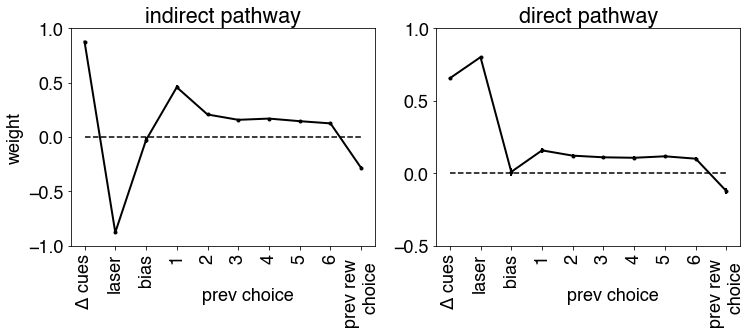

In [6]:
from glmhmm.visualize import plot_weights

# plot the inferred weights probabilities
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12, 4)
colors = np.array([[0,0,0]])/255
xlabels = ['$\Delta$ cues', 'laser', 'bias', '1', '2', '3', '4', '5', '6', 'prev rew \n choice']

# indirect pathway
plot_weights(w_d2[:,1].reshape(1,-1),axes[0],switch=True,xlabels=xlabels,style='.-',color=colors,error=variance_d2)
axes[0].text(0.43,-0.25,'prev choice',transform=axes[0].transAxes)
axes[0].set_title('indirect pathway')
axes[0].set_ylim([-1,1])
axes[0].set_yticks(np.arange(-1,1.5,0.5))

# direct pathway
plot_weights(w_d1[:,1].reshape(1,-1),axes[1],switch=True,xlabels=xlabels,style='.-',color=colors,error=variance_d1)
axes[1].text(0.43,-0.25,'prev choice',transform=axes[1].transAxes)
axes[1].set_title('direct pathway')
axes[1].set_ylim([-0.5,1])
axes[1].set_yticks(np.arange(-0.5,1.5,0.5))
axes[1].set_ylabel('')

We can then simulate data from the fitted models and compare the psychometric curves to see if they match.

In [7]:
# simulate data from indirect pathway cohort
sim_GLM_d2 = glm.GLM(N_d2,M,C,observations="bernoulli")
sim_x_d2,sim_y_d2 = sim_GLM_d2.generate_data_from_fit(w_d2,x_d2,obs_ix=[3,9],replace_obs=True,sessions=sessions_d2)
# simulate data from direct pathway cohort
sim_GLM_d1 = glm.GLM(N_d1,M,C,observations="bernoulli")
sim_x_d1,sim_y_d1 = sim_GLM_d1.generate_data_from_fit(w_d1,x_d1,obs_ix=[3,9],replace_obs=True,sessions=sessions_d1)

To plot separate psychometric curves for the "laser on" and "laser off" trials using a "contra - ipsi" y-axis, we'll need to convert the choices on inhibition trials for one hemisphere. Because the hemisphere of inhibition is determined by the date of the behavior session (even or odd dates), we'll also need to load that information.
In order to have the right x-axis, we'll also want the actual delta cues (not standardized). To get these values, we simply need to multiply the standardized delta cues by the standard deviation of the original values, which happens to be 6.5.

In [44]:
from glmhmm.utils import convertContraIpsi

# load date information
dates_d2 = np.load('../data/indirect_dates.npy')
dates_d1 = np.load('../data/direct_dates.npy')

## INDIRECT PATHWAY
# convert to contra-ipsi (real data)
save_path = '../examples/matlab/psychometric_data_d2.mat'
dict_real = convertContraIpsi(x_d2[:,2], x_d2[:,1], y_d2, dates_d2, save_path, scale=6.5)
# convert to contra-ipsi (simulated data)
save_path = '../examples/matlab/psychometric_simulated_d2.mat'
dict_sim = convertContraIpsi(x_d2[:,2],x_d2[:,1], sim_y_d2, dates_d2, save_path, scale=6.5)

## DIRECT PATHWAY
# convert to contra-ipsi (real data)
save_path = '../examples/matlab/psychometric_data_d1.mat'
dict_real = convertContraIpsi(x_d1[:,2], x_d1[:,1], y_d1, dates_d1, save_path, scale=6.5)
# convert to contra-ipsi (simulated data)
save_path = '../examples/matlab/psychometric_simulated_d1.mat'
dict_sim = convertContraIpsi(x_d1[:,2],x_d1[:,1], sim_y_d1, dates_d1, save_path, scale=6.5)

Now we have everything we need to plot the psychometric curves. <b>Note:</b> To run this locally, you'll need to have a copy of MATLAB 2019b as well as the MATLAB Engine API for Python installed on your computer (see more info [here](https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html)).

In [59]:
from glmhmm.visualize import plot_psychometrics

colors = [[0, 0, 0],[0.5, 0.85, 0]]
title = ['data','model','data','model']
path_string = '../examples/matlab/psychometric'
file_path = ['%s_data_d2.mat' %(path_string),'%s_simulated_d2.mat' %(path_string),\
             '%s_data_d1.mat' %(path_string),'%s_simulated_d1.mat' %(path_string)]
save_path = ['%s_data_d2.png' %(path_string),'%s_simulated_d2.png' %(path_string),\
             '%s_data_d1.png' %(path_string),'%s_simulated_d1.png' %(path_string)]

for i in range(4):
    plot_psychometrics(colors,title[i],file_path[i],save_path[i])

# display saved matlab plots inline
import ipywidgets as widgets
import IPython.display as display
img1 = open('../examples/matlab/psychometric_data_d2.png', 'rb').read()
img2 = open('../examples/matlab/psychometric_simulated_d2.png', 'rb').read()
img3 = open('../examples/matlab/psychometric_data_d1.png', 'rb').read()
img4 = open('../examples/matlab/psychometric_simulated_d1.png', 'rb').read()
wi1 = widgets.Image(value=img1, format='png', width=200, height=100)
wi2 = widgets.Image(value=img2, format='png', width=200, height=100)
wi3 = widgets.Image(value=img3, format='png', width=200, height=100)
wi4 = widgets.Image(value=img4, format='png', width=200, height=100)
display.display(widgets.HBox([wi1, wi2, wi3, wi4]))

We can see from these plots that the psychometrics for the real and simulated data don't match very closely. So instead, we can consider a variant of the standard GLM that might better describe choice behavior. 

One possibility is that mice use a weighting function that changes over time. To test this idea, we can fit a latent state model that allows for different GLM weights in different states. This hybrid model consists of a GLM along with a Hidden Markov Model (HMM) and is known as a GLM-HMM. To see how we fit this model to the data from our paper, see the <code>Figure_6.ipynb</code> and <code>Figure_7.ipynb</code> notebooks. To see how the performance of the GLM and GLM-HMM models compare, see the <code>Figure_5.ipynb</code> notebook.

------------
### Comparing Performance of GLM and GLM-HMM

First, let's split our data into train and test sets. This can be a little tricky to do with real data, as we don't necessarily want to split the data randomly. Instead, we'll want to preserve session structure (as opposed to splitting trials within sessions). Because of individual differences in animals, we'll also want to try to balance the test sets so that they contain approximately the same number of sessions per mouse. 

In [541]:
from glmhmm.utils import splitData

mouseIDs_d1 = np.load('../data/direct_mouseIDs.npy')

results = splitData(sessions_d1,mouseIDs_d1,testSize=0.2,seed=0)

[59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76.
 77. 78. 79. 80. 81. 82. 83. 84. 85.]
[ 87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100.
 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114.
 115.]
[117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130.
 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144.]
[159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169.]
[171. 172. 173. 174. 175. 176.]
[178. 179. 180. 181. 182. 183. 184. 185.]
[187. 188. 189. 190. 191. 192.]
[194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207.
 208. 209. 210.]
[212. 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225.
 226. 227. 228. 229. 230. 231.]
[233. 234. 235. 236. 237. 238. 239. 240. 241. 242. 243. 244. 245. 246.
 247. 248. 249. 250. 251. 252. 253. 254. 255. 256. 257. 258. 259. 260.
 261. 262. 263. 264. 265.]
[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 

In [543]:
sessions_d1

array([    0,   164,   319,   501,   642,   656,   755,   787,   791,
         940,  1028,  1072,  1178,  1297,  1411,  1437,  1563,  1647,
        1743,  1850,  1992,  2133,  2294,  2419,  2449,  2582,  2713,
        2858,  3017,  3147,  3251,  3398,  3615,  3841,  4090,  4323,
        4533,  4723,  4933,  5157,  5341,  5511,  5723,  5889,  5925,
        6035,  6212,  6384,  6542,  6730,  6887,  6898,  6970,  7016,
        7084,  7284,  7309,  7447,  7664,  7890,  8148,  8413,  8621,
        8882,  9123,  9368,  9543,  9681,  9910, 10154, 10404, 10621,
       10782, 11048, 11282, 11552, 11797, 12071, 12310, 12537, 12763,
       13030, 13235, 13460, 13719, 13963, 14177, 14209, 14217, 14402,
       14590, 14804, 15024, 15268, 15508, 15738, 15954, 16188, 16407,
       16644, 16889, 17110, 17329, 17561, 17779, 18006, 18226, 18473,
       18699, 18915, 19142, 19403, 19637, 19859, 20102, 20345, 20577,
       20760, 20939, 21115, 21289, 21495, 21665, 21865, 22019, 22143,
       22337, 22515,

In [506]:
# split the data into five folds
folds = 5
train_size = int(N - N/folds)
test_size = int(N/folds)
y_train = np.zeros((folds,train_size))
y_test = np.zeros((folds,test_size))
x_train = np.zeros((folds,train_size,D))
x_test = np.zeros((folds,test_size,D))
kf = KFold(n_splits=folds)
kf.get_n_splits(true_y)
for i, (train_index, test_index) in enumerate(kf.split(true_y)):
    y_train[i,:], y_test[i,:] = y_d2[train_index], y_d2[test_index]
    x_train[i,:,:], x_test[i,:,:] = y_d2[train_index], y_d2[test_index]

NameError: name 'N' is not defined